[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ArtIC-TITECH/b3-proj-2024/blob/main/docs/theme_F.ipynb)

# モデルの敵対的サンプルへの耐性評価

以下のセルはモデルが誤分類するように入力画像を変化させるFast Gradient Sign Method (FGSM)の実装です。

Epoch 1, Loss: 0.4977
Epoch 2, Loss: 0.1917
Epoch 3, Loss: 0.0829


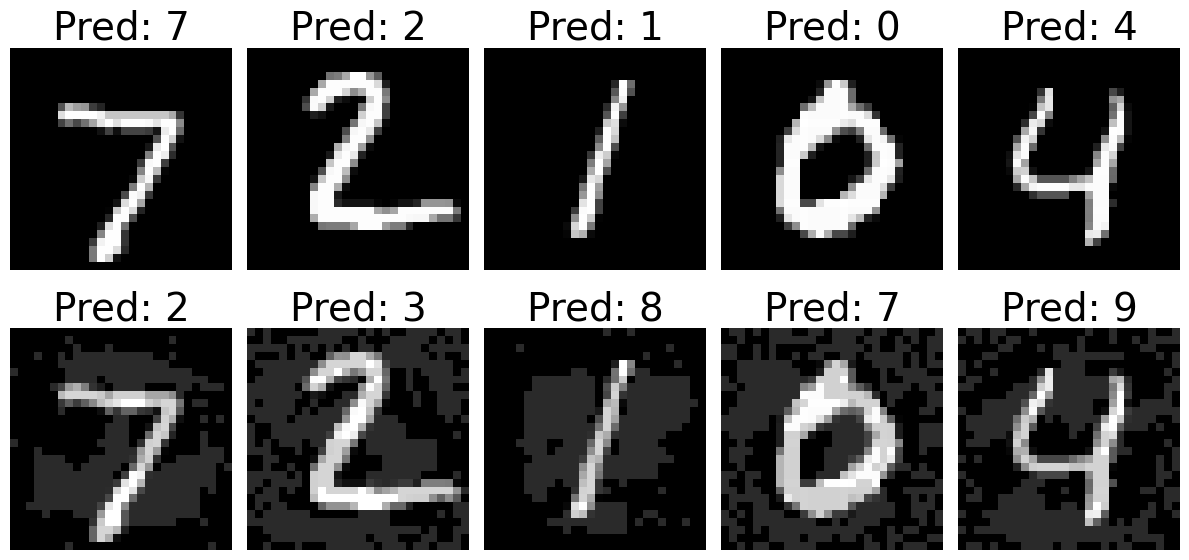

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# MNISTデータセットの読み込みと前処理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# モデルの定義（シンプルなニューラルネットワーク）
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# モデルのインスタンス化
model = SimpleNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 損失関数と最適化手法
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# モデルのトレーニング
def train(model, trainloader, criterion, optimizer, device, epochs=3):
    for epoch in range(epochs):
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# モデルを訓練
train(model, trainloader, criterion, optimizer, device)

# FGSMによる敵対的サンプルの生成
def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    data_grad = images.grad.data
    sign_data_grad = data_grad.sign()
    perturbed_image = images + epsilon * sign_data_grad
    return perturbed_image

# 敵対的サンプルを生成し、元画像と並べて予測と共に表示する
def display_adversarial_examples(model, testloader, epsilon, device):
    model.eval()
    images, labels = next(iter(testloader))
    images, labels = images.to(device), labels.to(device)

    # FGSMで敵対的サンプルを生成
    perturbed_images = fgsm_attack(model, images, labels, epsilon)

    # モデルによる予測結果を取得
    original_outputs = model(images)
    perturbed_outputs = model(perturbed_images)

    _, original_preds = torch.max(original_outputs, 1)
    _, perturbed_preds = torch.max(perturbed_outputs, 1)

    # 元画像と敵対的サンプルを表示
    plt.figure(figsize=(12, 6))
    for i in range(5):
        # 元画像を表示
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].cpu().detach().numpy().squeeze(), cmap='gray')
        plt.title(f"Pred: {original_preds[i].item()}", fontsize=28)
        plt.axis('off')

        # 敵対的サンプルを表示
        plt.subplot(2, 5, i+6)
        plt.imshow(perturbed_images[i].cpu().detach().numpy().squeeze(), cmap='gray')
        plt.title(f"Pred: {perturbed_preds[i].item()}", fontsize=28)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# ε（epsilon）を設定して、敵対的サンプルを表示
epsilon = 0.2
display_adversarial_examples(model, testloader, epsilon, device)


FGSMによるモデルへの攻撃で分類精度は大きく低下します。

In [2]:
# テスト精度を計算する関数
def test_accuracy(model, testloader, device):
    model.eval()  # 評価モード
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# FGSMによる攻撃を受けた後のテスト精度を計算する関数
def test_accuracy_with_fgsm(model, testloader, epsilon, device):
    model.eval()  # 評価モード
    correct = 0
    total = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        # FGSMで敵対的サンプルを生成
        perturbed_images = fgsm_attack(model, images, labels, epsilon)

        # 敵対的サンプルでモデルの精度を計算
        outputs = model(perturbed_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# FGSMなしでテスト精度を計算
clean_accuracy = test_accuracy(model, testloader, device)
print(f"Accuracy on clean test data: {clean_accuracy:.2f}%")

# FGSMありでテスト精度を計算
epsilon = 0.2
adversarial_accuracy = test_accuracy_with_fgsm(model, testloader, epsilon, device)
print(f"Accuracy on adversarial test data (epsilon={epsilon}): {adversarial_accuracy:.2f}%")


Accuracy on clean test data: 95.52%
Accuracy on adversarial test data (epsilon=0.2): 10.64%
